In [1]:
import os
import sys
from pathlib import PurePath
from functools import partial
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from backtest import backtest, pct_commission

workspace_root = str(PurePath(os.getcwd()))
sys.path.append(workspace_root)

Let's begin by loading our data.

We transform a flat file of candlestick (kline) data for a variety of crypto assets into the required format for backtesting: a single level DatetimeIndex with a column for each asset.

In [2]:
def ohlcv_from_csv(filename):
    return pd.read_csv(
        filename,
        index_col=["symbol", "dt"],
        parse_dates=["dt"],
        dtype={
            "o": np.float64,
            "h": np.float64,
            "l": np.float64,
            "c": np.float64,
            "v": np.float64,
        },
    )


prices_filename = f"{workspace_root}/tests/testdata/binance-margin-1d.csv"
market = ohlcv_from_csv(prices_filename)
market = market[~market.index.duplicated()]
market = market.unstack(level=0).sort_index(axis=1).stack()

# Price series for valuation of the asset at each interval.
mark_prices = pd.DataFrame(
    market.loc[:, ["c"]].unstack(level=1).droplevel(level=0, axis=1)
)

# Price series to build our strategy weights.
strategy_prices = pd.DataFrame(
    market.loc[:, ["c"]].unstack(level=1).droplevel(level=0, axis=1)
)

/var/folders/4f/ws_sglpd7bq9yh4t4xnghjmc0000gp/T/ipykernel_53999/1918015241.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.read_csv(


To create our weights we build a simple risk-adjusted moving average cross forecast.

In [3]:
vola = strategy_prices.diff().ewm(span=20).std()

lookback = 32
forecast = (
    strategy_prices.ewm(span=lookback).mean()
    - strategy_prices.ewm(span=lookback * 4).mean()
).div(vola)

Next we create our strategy weights by scaling the forecast for each asset to the range -1 (short) to +1 (long).

Note we use a rolling scaling method to prevent lookahead bias.

Portfolio uses equal weights.

In [4]:
def roll_scale(x: pd.DataFrame, scaler, window=252, min_periods=90):
    return x.rolling(window=window, min_periods=min_periods).apply(
        lambda x: scaler(x).iloc[-1]
    )


def minmax_scale(x, min=None, max=None):
    min = np.min(x) if min is None else min
    max = np.max(x) if max is None else max
    scale = 2 / (max - min) if (max - min) != 0 else 1
    shift = -1 - min * scale
    return x * scale + shift


assets_n = len(forecast.columns)
weights = forecast.pipe(roll_scale, scaler=minmax_scale).mul(1 / assets_n)

Finally we are ready to backtest.

However, before we do we take care to align the mark prices to the weights, the shape of each dataframe must match.

During the backtest the weights will be _shifted_ to prevent look-ahead bias.

Note this is a cost-aware backtest with leverage, we've chosen parameters that mimic a typical crypto exchange.

In [5]:
mark_prices = mark_prices.mask(weights.isna())
mark_prices, weights = mark_prices.align(weights, join="inner")

perf, perf_cum, perf_sr, port_perf, port_cum = backtest(
    weights,
    mark_prices,
    leverage=2,
    freq_day=1,
    commission_func=partial(pct_commission, fee=0.001),
    ann_borrow_pct=0.05,
    spread_pct=0.001,
)

Lets look at the performance of the strategy, starting with the asset-wise view, then the portfolio view.

Note Sharpe and volatility are annualized measures.

asset                       strategy                       \
             sharpe volatility      cagr    sharpe volatility      cagr   
symbol                                                                    
BTCUSDT    0.885743   0.572544  0.404435  0.655047   0.116346  0.071916   
DOGEUSDT   0.787412   1.964974  0.799934  0.366883   0.544911  0.114876   
ETHUSDT    0.919363   0.728353  0.488474  0.196096   0.156454  0.018566   
MATICUSDT  1.153496   1.196962  0.983925  0.504530   0.259935  0.102387   
SOLUSDT    1.249379   1.095864  1.160662  1.059392   0.230253  0.242927   
XRPUSDT    0.557395   0.924125  0.116877 -0.464994   0.161284 -0.084298   

                                            
          trades_per_day profit_cost_ratio  
symbol                                      
BTCUSDT         0.940565          0.699020  
DOGEUSDT        0.932846          1.203058  
ETHUSDT         0.932487          0.154482  
MATICUSDT       0.918043          1.066655  
SOLUSDT         0.928247          2.864799  
XRPUSDT         0.945182         -0.518642

<Axes: xlabel='dt'>

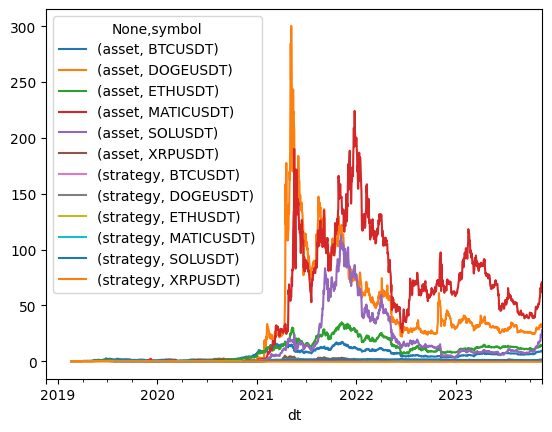

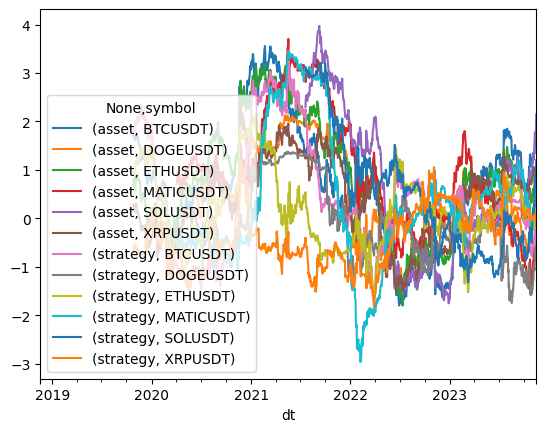

In [6]:
display(perf)
perf_cum.plot()
perf_sr.plot()

,sharpe,volatility,cagr,profit_cost_ratio
strategy,0.56907,0.799949,0.191655,5.469372


<Axes: xlabel='dt'>

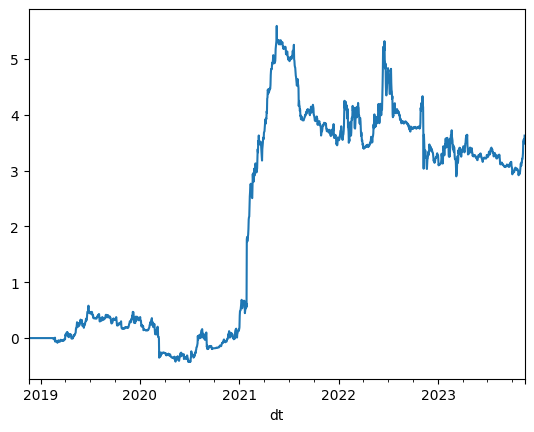

In [7]:
display(port_perf)
port_cum.plot()